In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#pip install matplotlib pillow
from IPython.display import Image

In [ ]:
def dice_loss(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    intersection = (preds * targets).sum(dim=(1,2,3,4))
    union = preds.sum(dim=(1,2,3,4)) + targets.sum(dim=(1,2,3,4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(preds, targets, bce_weight=0.5):
    bce = nn.BCEWithLogitsLoss()(preds, targets)
    dice = dice_loss(preds, targets)
    return bce_weight * bce + (1 - bce_weight) * dice

In [ ]:


class conv3d_inplace_spatial(nn.Module):
    def __init__(self, in_channels, out_channels, pooling_function, activation=nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(out_channels),
            nn.GELU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)


class Upscale(nn.Module):
    def __init__(self, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet_Video(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self.mpool_2 = nn.MaxPool3d((1, 2, 2))

        # Down path
        self.down1 = conv3d_inplace_spatial(in_channels, 32, self.mpool_2)
        self.down2 = conv3d_inplace_spatial(32, 64, self.mpool_2)
        self.down3 = conv3d_inplace_spatial(64, 128, self.mpool_2)
        self.down4 = conv3d_inplace_spatial(128, 256, self.mpool_2)

        # Up path
        self.upscale_2 = Upscale()
        self.up1 = conv3d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv3d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv3d_inplace_spatial(128, 32, self.upscale_2)
        self.up4 = conv3d_inplace_spatial(64, 1, self.upscale_2, activation=nn.Identity())

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        u1 = self.up1(x4)
        u1 = torch.cat((x3, u1), dim=1)
        u2 = self.up2(u1)
        u2 = torch.cat((x2, u2), dim=1)
        u3 = self.up3(u2)
        u3 = torch.cat((x1, u3), dim=1)
        out = self.up4(u3)
        return out

    def predict(self, inputs, targets):
        preds = self(inputs)
        loss = combined_loss(preds, targets)
        metrics = calculate_metrics(preds, targets)
        metrics["loss"] = loss.item()
        return loss, metrics


In [ ]:
def calculate_metrics(preds, labels):
    with torch.no_grad():
        preds_bin = (torch.sigmoid(preds) > 0.5).float()
        intersection = (preds_bin * labels).sum()
        union = ((preds_bin + labels) > 0).float().sum()
        iou = intersection / (union + 1e-6)
        return {"iou": iou.item()}


In [ ]:
class VideoModalToAmodalDataset(Dataset):
    def __init__(self, sample_dir, num_frames=24):
        self.sample_dir = Path(sample_dir)
        self.sample_dict = self.get_sample_dict(self.sample_dir)
        self.cameras = sorted([p.name for p in self.sample_dir.glob("camera_*")])
        self.obj_ids = [x for x in self.sample_dict[self.cameras[0]] if 'obj_' in x]
        self.num_frames = num_frames

    def __len__(self):
        return len(self.obj_ids) * len(self.cameras)

    def __getitem__(self, idx):
        max_retries = 10  # avoid infinite loop

        for _ in range(max_retries):
            cam_idx = idx // len(self.obj_ids)
            obj_idx = idx % len(self.obj_ids)

            cam_name = self.cameras[cam_idx]
            obj_id = self.obj_ids[obj_idx]

            rgb_seq = []
            try:
                for frame_idx in range(self.num_frames):
                    rgb_path = self.sample_dict[cam_name]['scene']['rgba'][frame_idx]
                    modal_path = self.sample_dict[cam_name]['scene']['segmentation'][frame_idx]
                    amodal_path = self.sample_dict[cam_name][obj_id]['segmentation'][frame_idx]

                    if not rgb_path.exists() or not modal_path.exists() or not amodal_path.exists():
                        raise FileNotFoundError(f"Missing file(s) for {cam_name} {obj_id} frame {frame_idx}")

                    rgb = ToTensor()(Image.open(rgb_path).convert('RGB'))
                    modal_np = np.array(Image.open(modal_path))
                    obj_int = int(obj_id.split('_')[1])
                    modal_mask = torch.tensor((modal_np == obj_int).astype(np.float32)).unsqueeze(0)
                    input_frame = torch.cat((rgb, modal_mask), dim=0)
                    rgb_seq.append(input_frame)

                video_tensor = torch.stack(rgb_seq).permute(1, 0, 2, 3)  # (4, T, H, W)

                amodal_mask_np = np.array(Image.open(amodal_path).convert('L')) / 255.0
                amodal_mask = torch.tensor(amodal_mask_np, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
                amodal_mask = amodal_mask.repeat(1, self.num_frames, 1, 1)  # (1, T, H, W)

                return video_tensor, amodal_mask

            except Exception as e:
                print(f"[WARNING] Skipping bad sample (cam={cam_name}, obj={obj_id}): {e}")
                idx = (idx + 1) % len(self)  # Try next index

        raise RuntimeError(f"[ERROR] Failed to get a valid sample after {max_retries} tries.")

    def get_sample_dict(self, sample_dir):
        def get_img_dict(img_dir):
            img_files = sorted(list(img_dir.glob("*.png")) + list(img_dir.glob("*.tiff")))
            img_dict = {}
            for f in img_files:
                key = f.name.split('_')[0]
                img_dict.setdefault(key, []).append(f)
            return img_dict

        sample_dict = {}
        for cam_dir in sorted(sample_dir.glob("camera_*")):
            cam_dict = {'scene': get_img_dict(cam_dir)}
            for obj_dir in sorted(cam_dir.glob("obj_*")):
                cam_dict[obj_dir.name] = get_img_dict(obj_dir)
            sample_dict[cam_dir.name] = cam_dict
        return sample_dict


In [ ]:
sample_dir = "ff5da6d6ecae486bb294aeaf5ee8f8a1"
dataset = VideoModalToAmodalDataset(sample_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet_Video().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
n_epochs = 20  # Change as needed

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        preds = model(inputs)  # forward pass
        loss = combined_loss(preds, targets)  # BCE + Dice
        metrics = calculate_metrics(preds, targets)  # e.g. IoU

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_iou += metrics["iou"]

    avg_loss = running_loss / len(train_loader)
    avg_iou = running_iou / len(train_loader)
    print(f"✅ Epoch {epoch+1} | Avg Loss: {avg_loss:.4f} | Avg IoU: {avg_iou:.4f}")




# Evaluate
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch = (batch[0].to(device), batch[1].to(device))
        loss, metrics = model(batch)
        total_loss += loss.item()
print(f"Average Test Loss: {total_loss / len(test_loader):.4f}")


✅ Epoch 1 | Avg Loss: 0.8319 | Avg IoU: 0.0337
✅ Epoch 2 | Avg Loss: 0.8007 | Avg IoU: 0.0773
✅ Epoch 3 | Avg Loss: 0.7785 | Avg IoU: 0.0915
✅ Epoch 4 | Avg Loss: 0.7587 | Avg IoU: 0.1052
✅ Epoch 5 | Avg Loss: 0.7403 | Avg IoU: 0.1197
✅ Epoch 6 | Avg Loss: 0.7231 | Avg IoU: 0.1308
✅ Epoch 7 | Avg Loss: 0.7092 | Avg IoU: 0.1377
✅ Epoch 8 | Avg Loss: 0.6946 | Avg IoU: 0.1394
✅ Epoch 9 | Avg Loss: 0.6806 | Avg IoU: 0.1486
✅ Epoch 10 | Avg Loss: 0.6685 | Avg IoU: 0.1475
✅ Epoch 11 | Avg Loss: 0.6577 | Avg IoU: 0.1544
✅ Epoch 12 | Avg Loss: 0.6470 | Avg IoU: 0.1578
✅ Epoch 13 | Avg Loss: 0.6374 | Avg IoU: 0.1573
✅ Epoch 14 | Avg Loss: 0.6273 | Avg IoU: 0.1642
✅ Epoch 15 | Avg Loss: 0.6195 | Avg IoU: 0.1507


KeyboardInterrupt: 

In [ ]:
# Visualize 1 test sample
model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    inputs, targets = batch[0].to(device), batch[1].to(device)
    preds = model(inputs)  # use model() directly

# Extract the first video in the batch
idx = 0
video = inputs[idx].cpu()  # shape: (4, T, H, W)
rgb_seq = video[0:3].permute(1, 2, 3, 0).numpy()         # (T, H, W, 3)
modal_mask_seq = video[3].numpy()                        # (T, H, W)
pred_amodal_seq = torch.sigmoid(preds[idx, 0]).cpu().numpy()  # (T, H, W)
pred_amodal_seq = (pred_amodal_seq > 0.5).astype(np.float32)  # Apply threshold
# (T, H, W)

# Set up animation
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
titles = ["RGB Frame", "Modal Mask", "True Amodal", "Predicted Amodal"]
ims = []

for t in range(rgb_seq.shape[0]):
    frame_imgs = []
    for ax, data, title in zip(axes,
                               [rgb_seq[t], modal_mask_seq[t], true_amodal_seq[t], pred_amodal_seq[t]],
                               titles):
        ax.set_title(title)
        ax.axis("off")
        if title == "RGB Frame":
            im = ax.imshow(data)
        else:
            im = ax.imshow(data, cmap='gray', vmin=0, vmax=1)
        frame_imgs.append(im)
    ims.append(frame_imgs)

# Create and save GIF
ani = animation.ArtistAnimation(fig, ims, interval=250, blit=True)
ani.save("amodal_prediction.gif", writer='pillow', dpi=100)
plt.close(fig)

print("✅ Saved GIF as amodal_prediction.gif")


✅ Saved GIF as amodal_prediction.gif


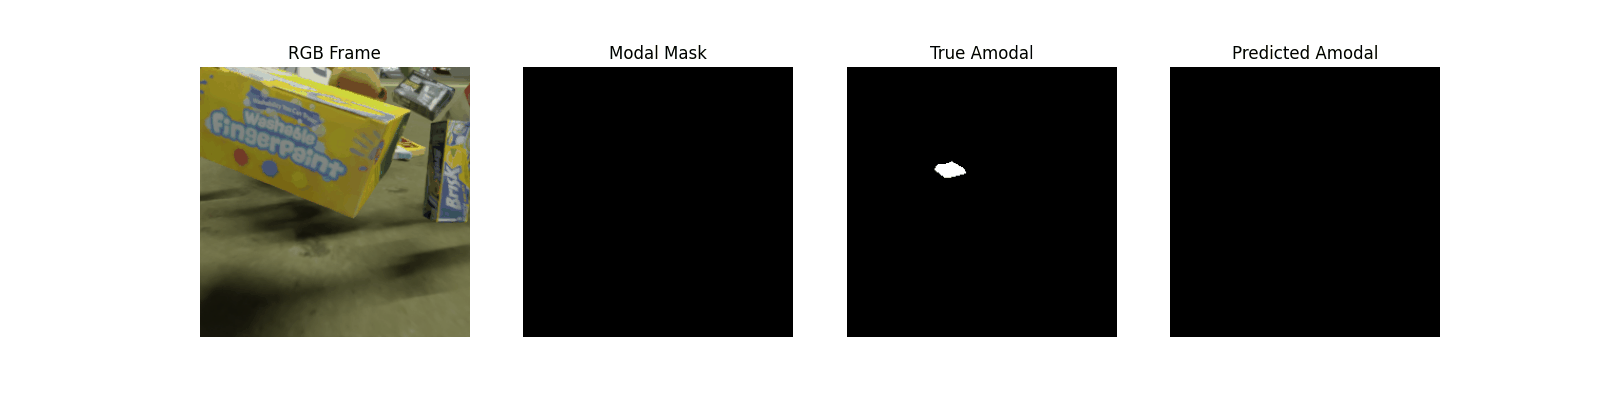

In [ ]:

Image(filename="amodal_prediction.gif")


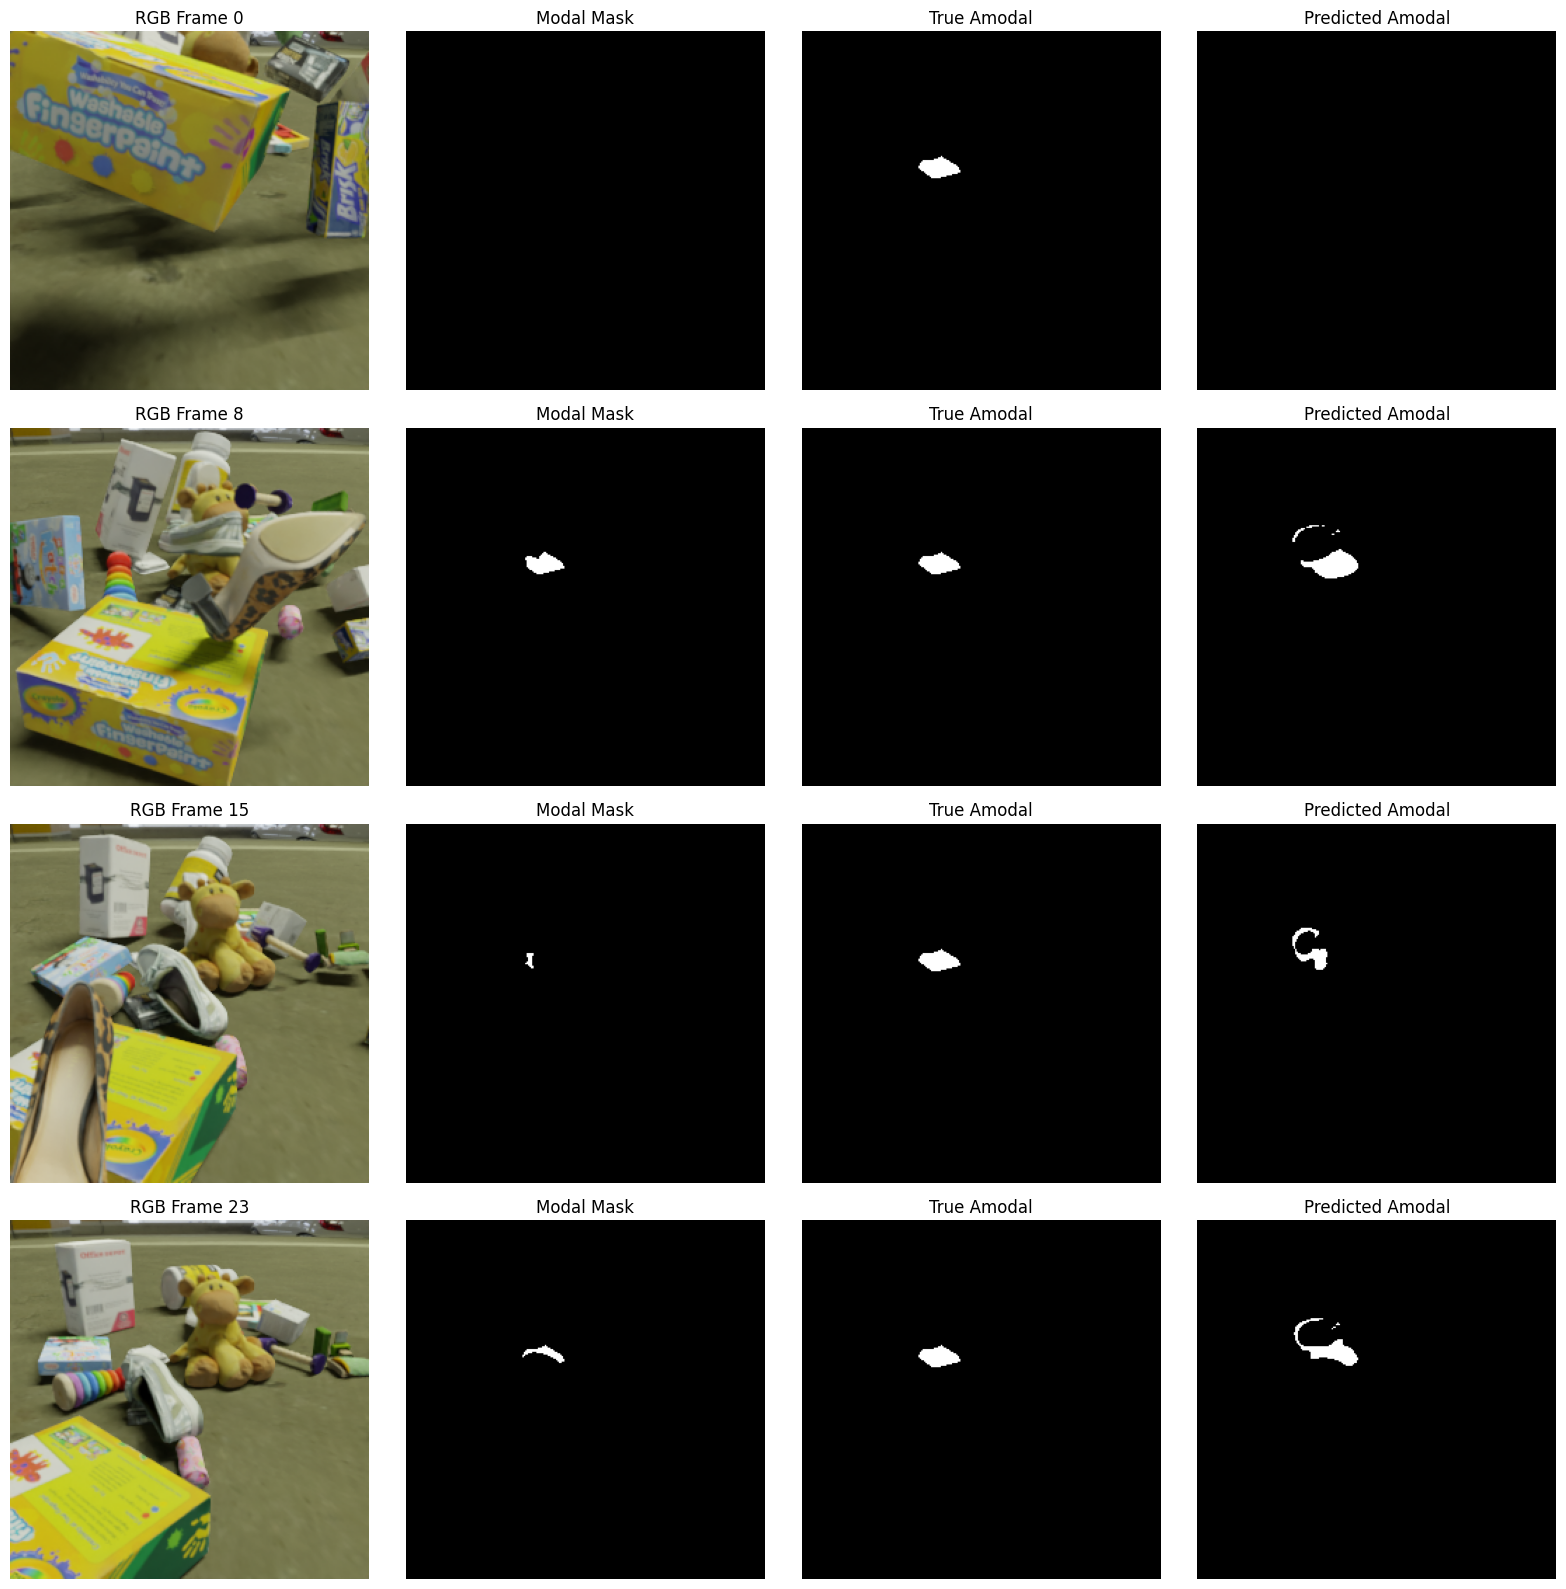

In [ ]:
frames_to_show = [0, 8, 15, 23]
fig, axes = plt.subplots(len(frames_to_show), 4, figsize=(16, 4 * len(frames_to_show)))

for i, t in enumerate(frames_to_show):
    axes[i][0].imshow(rgb_seq[t])
    axes[i][0].set_title(f"RGB Frame {t}")

    axes[i][1].imshow(modal_mask_seq[t], cmap='gray')
    axes[i][1].set_title("Modal Mask")

    axes[i][2].imshow(true_amodal_seq[t], cmap='gray')
    axes[i][2].set_title("True Amodal")

    axes[i][3].imshow(pred_amodal_seq[t], cmap='gray', vmin=0, vmax=1)
    axes[i][3].set_title("Predicted Amodal")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()


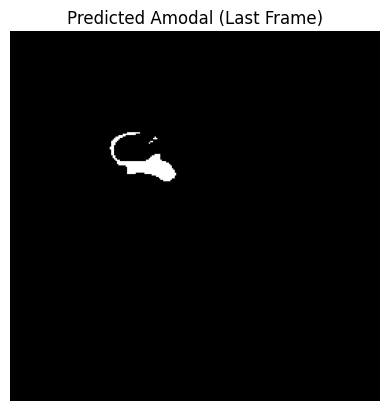

In [ ]:
t = -1  # Last frame
fig, ax = plt.subplots(1, 1)
ax.imshow(pred_amodal_seq[t], cmap='gray')
ax.set_title("Predicted Amodal (Last Frame)")
ax.axis("off")
plt.show()
